In [1]:
# For each iteration of outputs, plot the objective functions for each basins and save to a PDF file

In [11]:
import numpy as np
import os, glob, sys, toml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import imageio
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

sys.path.append('/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src')
import NSGA2

# Load data

In [12]:
# basin info
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(file)

In [13]:
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange'
basinnum = 627
iternum = 3
trialnum = 400 + (iternum-1)*40

# 2: GPR, RF; 
emulator_metrics = np.nan * np.zeros([basinnum, iternum, 2]) 

model_metrics = np.nan * np.zeros([basinnum, trialnum, 3]) # metric-1, metric-2, iter 


for i in range(basinnum):

    flag = 0
    for j in range(iternum):
        # emulator metrics
        infiles_ij = [f'{inpath}/level1_{i}_MOASMOcalib/param_sets/GPR_for_iter{j}_CV_kge.csv', 
                      f'{inpath}/level1_{i}_MOASMOcalib/param_sets/RF_for_iter{j}_CV_kge.csv']
        for p in range(2):
            infile_ijp = infiles_ij[p]
            df = pd.read_csv(infile_ijp)
            emulator_metrics[i, j, p] = df['kge_mean'].values[-1]
        
        # ctsm model metrics
        filemet = f'{inpath}/level1_{i}_MOASMOcalib/ctsm_outputs/iter{j}_all_metric.csv'
        dfi = pd.read_csv(filemet)
        dfi['iter'] = j

        model_metrics[i, flag:flag+len(dfi), :] = dfi.values

        flag = flag+len(dfi)
        

# Pareto rank analysis
1. I have results from all iterations
2. I calculate the rank of all simulations for all iterations
3. For each iteration, I calculate the mean rank from its simulations and minimum rank from its simulations
4. I plot the mean rank and minimum rank with iterations

For the minimum rank, if it decreases with iterations, this is means calibration finds better solutions. For mean rank, it is less obvious compared to minimum rank because it shows the average of all simulations within an iteration.

In [14]:
file = 'MOASMO_bigrange_rank_iter0-2.npz'
if os.path.isfile(file):
    dtmp = np.load(file)
    allranks = dtmp['allranks']

else:

    allranks = np.zeros([basinnum, trialnum])
    for tarbasin in range(0, basinnum):
        met = model_metrics[tarbasin, :, 0:2]
        rank, dom = NSGA2.fast_non_dominated_sort(met)
        allranks[tarbasin,:] = rank

    np.savez_compressed(file,allranks=allranks)

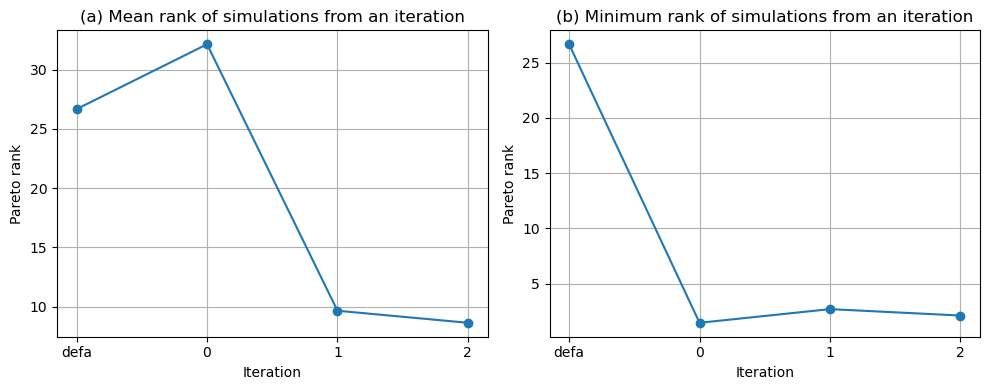

In [19]:
# mean / min Pareto rank

iterranks = np.nan * np.zeros([basinnum, iternum, 2])
defaranks = np.nan * np.zeros(basinnum)

for tarbasin in range(0, basinnum):
    iters = model_metrics[tarbasin, :, 2]
    rank = allranks[tarbasin,:]
    defaranks[tarbasin] = rank[0]
    for i in range(iternum):
        ranki = rank[iters==i]
        iterranks[tarbasin,i,0] = np.mean(ranki)
        iterranks[tarbasin,i,1] = np.min(ranki)

# mean ranks
iternames = ['defa'] + list(np.arange(iternum))

fig = plt.figure(figsize=[10, 4])

fig.add_subplot(1,2,1)
d1 = np.nanmean(iterranks[:,:,0],axis=0)
d2 = np.nanmean(defaranks)
plt.plot(iternames, np.hstack([d2, d1]), '-o')
plt.grid('on')
plt.xlabel('Iteration')
plt.ylabel('Pareto rank')
plt.title('(a) Mean rank of simulations from an iteration')


fig.add_subplot(1,2,2)
d1 = np.nanmean(iterranks[:,:,1],axis=0)
d2 = np.nanmean(defaranks)
plt.plot(iternames, np.hstack([d2, d1]), '-o')
plt.grid('on')
plt.xlabel('Iteration')
plt.ylabel('Pareto rank')
plt.title('(b) Minimum rank of simulations from an iteration')

plt.tight_layout()
# plt.savefig('allbasin_mean_min_rank.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

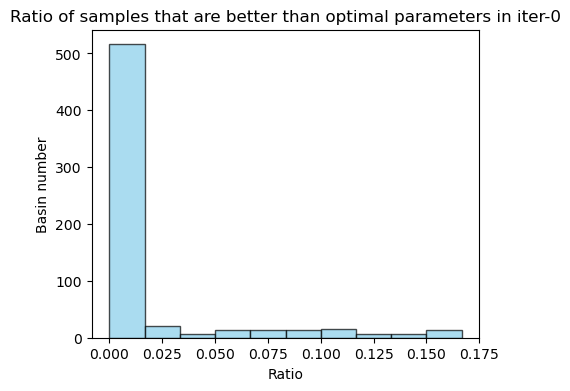

In [20]:
# iteration-0 has Pareto rank 0 (i.e., best parameters)
iter0_best_ratio = np.nan * np.zeros(basinnum)

iters = model_metrics[0, :, 2]
index = iters == 0
for i in range(basinnum):
    ranki = allranks[i]
    iter0_best_ratio[i] = np.sum(ranki < np.min(ranki[index])  ) / np.sum(ranki>=0)

fig = plt.figure(figsize=[5, 4])
plt.hist(iter0_best_ratio, facecolor='skyblue', edgecolor='k', alpha=0.7)
plt.xlabel('Ratio')
plt.ylabel('Basin number')
plt.title('Ratio of samples that are better than optimal parameters in iter-0')
# plt.savefig('iter0_pareto_front_ratio.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Improvement compared to default parameters

Select a parameter set from Pareto front

In [21]:
# obtain metrics

def select_one_from_pareto_front(front_points, defa_point, optimal_point=[0, 0]):
    # 1. step-1: find points that are better than defa_point for two metrics
    index = np.where((front_points[:, 0] <= defa_point[0]) & (front_points[:, 1] <= defa_point[1]))[0]
    
    if len(index) == 0:
        return defa_point

    front_points = front_points[index, :]

    if len(index) == 1:
        return front_points[0]

    # 2. step-2: find a point that is the closest to the optimal point (after normalization)
    norm_x = (front_points[:, 0] - optimal_point[0]) / (np.nanmax(front_points[:, 0]) - np.nanmin(front_points[:, 0]))
    norm_y = (front_points[:, 1] - optimal_point[1]) / (np.nanmax(front_points[:, 1]) - np.nanmin(front_points[:, 1]))
    dist = norm_x ** 2 + norm_y ** 2
    return front_points[np.argmin(dist)]

defa_metrics = model_metrics[:, 0, :2]
optmz_metrics = np.nan * np.zeros([basinnum, 2])

for i in range(basinnum):
    ranki = allranks[i, :].copy()
    ranki[0] = np.inf
    optmz_meti = model_metrics[i, ranki == 0, :2]
    optmz_metrics[i, :] = select_one_from_pareto_front(optmz_meti, defa_metrics[i, :], [0, 0])


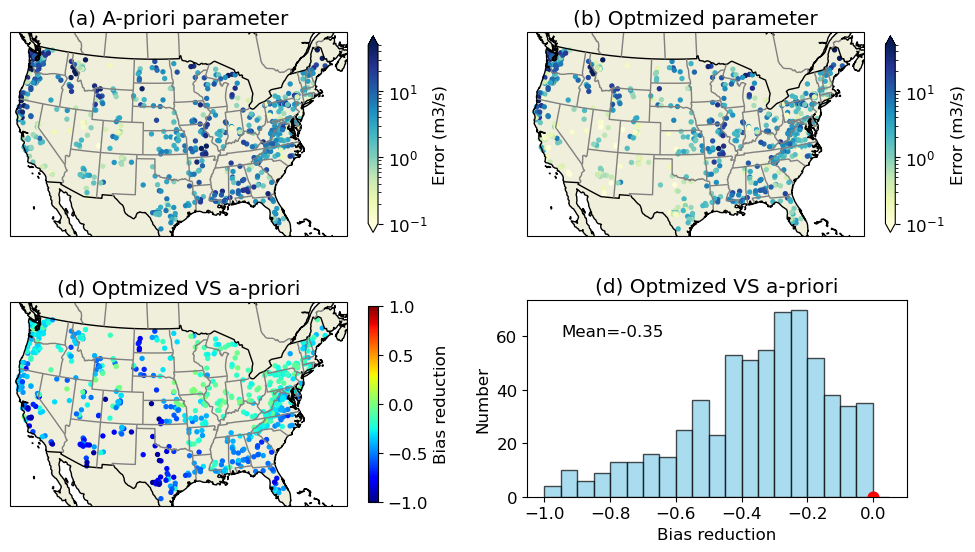

In [22]:
# plot metrics

lat = df_info['lat_cen'].values
lon = df_info['lon_cen'].values

met = np.vstack([defa_metrics[:, 0], optmz_metrics[:, 0]]).T

font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, 6])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

ax = fig.add_subplot(2, 2, 1, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 8, met[:,0], cmap='YlGnBu', norm=LogNorm(vmin=0.1, vmax=50), transform=transf)
ax.set_title('(a) A-priori parameter')
cax = plt.colorbar(p, ax=ax, label="Error (m3/s)", location='right', extend='both', shrink=0.8)

ax = fig.add_subplot(2, 2, 2, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 8, met[:,1], cmap='YlGnBu', norm=LogNorm(vmin=0.1, vmax=50), transform=transf)
ax.set_title('(b) Optmized parameter')
cax = plt.colorbar(p, ax=ax, label="Error (m3/s)", location='right', extend='both', shrink=0.8)

ax = fig.add_subplot(2, 2, 3, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 8, (met[:,1] - met[:,0]) / met[:,0], cmap='jet', vmin=-1, vmax=1, transform=transf)
ax.set_title('(d) Optmized VS a-priori')
cax = plt.colorbar(p, ax=ax, label="Bias reduction", location='right', shrink=0.8)

ax4 = fig.add_subplot(2, 2, 4)
ax4.hist((met[:,1] - met[:,0]) / met[:,0], np.arange(-1, 0.1, 0.05), color='skyblue', edgecolor='black', alpha=0.7)
ax4.scatter(0, 0, 60, color='r')
ax4.set_title('(d) Optmized VS a-priori')
ax4.set_xlabel('Bias reduction')
ax4.set_ylabel('Number')

me = np.nanmean((met[:,1] - met[:,0]) / met[:,0])
ax4.text(-0.95, 60, f'Mean={me:.2f}')

plt.tight_layout()

pos1 = ax4.get_position()  # Get the original position
pos2 = [pos1.x0, pos1.y0+0.05, pos1.width*0.9, pos1.height * 0.8]  # Modify the height
ax4.set_position(pos2)  # Set the new position

# plt.savefig('MOASMO_calib_MAE_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()


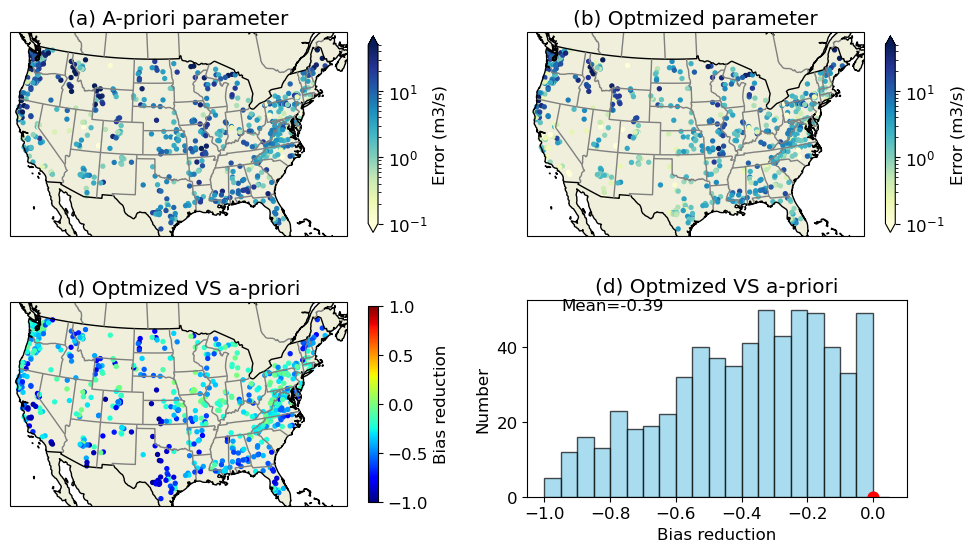

In [26]:
# plot metrics
lat = df_info['lat_cen'].values
lon = df_info['lon_cen'].values

met = np.vstack([defa_metrics[:, 1], optmz_metrics[:, 1]]).T

font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, 6])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

ax = fig.add_subplot(2, 2, 1, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 8, met[:,0], cmap='YlGnBu', norm=LogNorm(vmin=0.1, vmax=50), transform=transf)
ax.set_title('(a) A-priori parameter')
cax = plt.colorbar(p, ax=ax, label="Error (m3/s)", location='right', extend='both', shrink=0.8)

ax = fig.add_subplot(2, 2, 2, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 8, met[:,1], cmap='YlGnBu', norm=LogNorm(vmin=0.1, vmax=50), transform=transf)
ax.set_title('(b) Optmized parameter')
cax = plt.colorbar(p, ax=ax, label="Error (m3/s)", location='right', extend='both', shrink=0.8)

ax = fig.add_subplot(2, 2, 3, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 8, (met[:,1] - met[:,0]) / met[:,0], cmap='jet', vmin=-1, vmax=1, transform=transf)
ax.set_title('(d) Optmized VS a-priori')
cax = plt.colorbar(p, ax=ax, label="Bias reduction", location='right', shrink=0.8)

ax4 = fig.add_subplot(2, 2, 4)
ax4.hist((met[:,1] - met[:,0]) / met[:,0], np.arange(-1, 0.1, 0.05), color='skyblue', edgecolor='black', alpha=0.7)
ax4.scatter(0, 0, 60, color='r')
ax4.set_title('(d) Optmized VS a-priori')
ax4.set_xlabel('Bias reduction')
ax4.set_ylabel('Number')

me = np.nanmean((met[:,1] - met[:,0]) / met[:,0])
ax4.text(-0.95, 50, f'Mean={me:.2f}')

plt.tight_layout()

pos1 = ax4.get_position()  # Get the original position
pos2 = [pos1.x0, pos1.y0+0.05, pos1.width*0.9, pos1.height * 0.8]  # Modify the height
ax4.set_position(pos2)  # Set the new position

# plt.savefig('MOASMO_calib_MMAE_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()


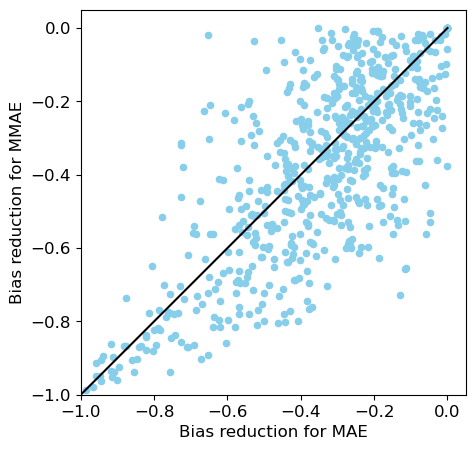

In [43]:
# relationship between bias reduction of two metrics

me = (optmz_metrics - defa_metrics) / defa_metrics

fig = plt.figure(figsize=[5, 5])

plt.scatter(me[:,0], me[:,1], 20, color='skyblue')
# plt.plot([-1,0],[0,0], 'k')
# plt.plot([0,0],[-1,0], 'k')
plt.plot([-1, 0], [-1, 0], color='k')
# plt.grid('on')
plt.xlim(-1, 0.05)
plt.ylim(-1, 0.05)
# plt.xticks([-1, -0.5, 0, 0.5, 1])
# plt.yticks([-1, -0.5, 0,])
plt.gca().set_aspect('equal')
plt.xlabel('Bias reduction for MAE')
plt.ylabel('Bias reduction for MMAE')
# plt.savefig('scatter_biasreduction_twometrics.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

[101 229 288 291 292 294 295 339 357 358]


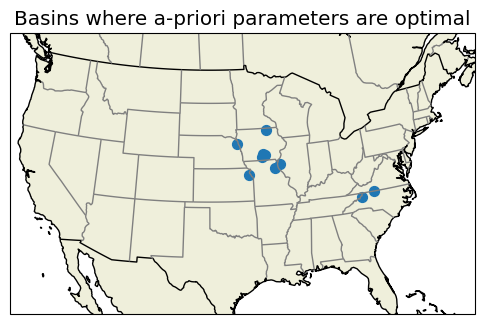

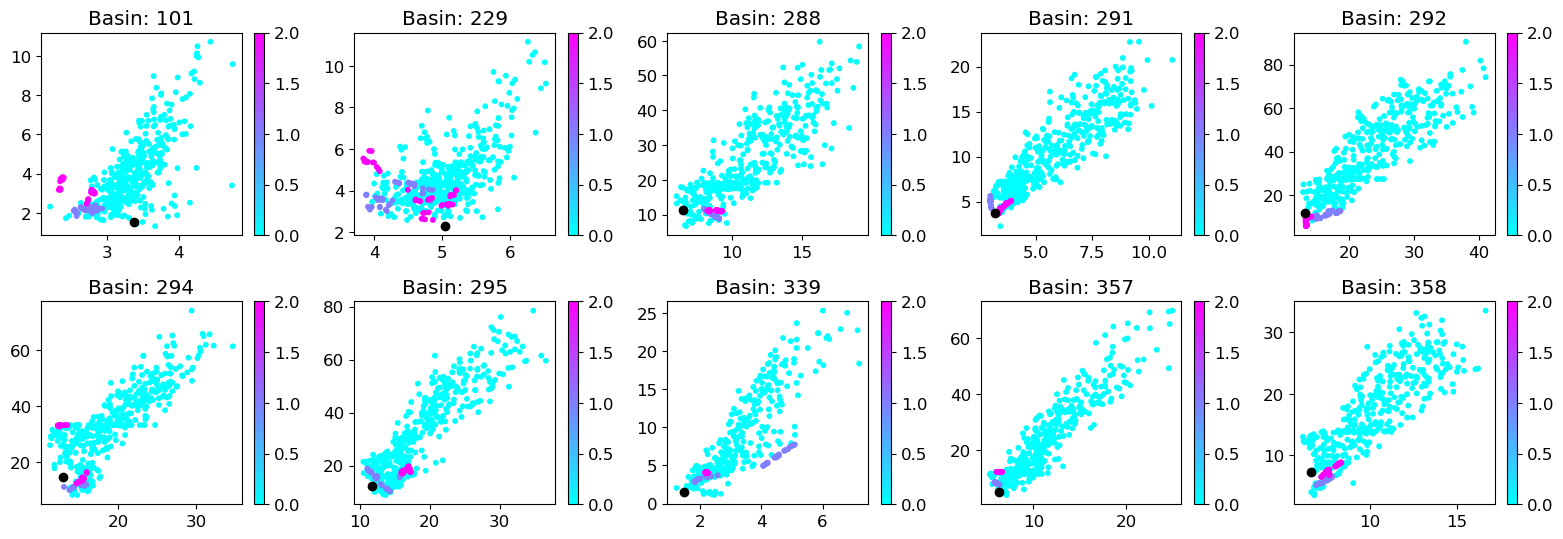

101: Find Default == Lower or Upper. DF len 14
229: Find Default == Lower or Upper. DF len 14
288: Find Default == Lower or Upper. DF len 15
291: Find Default == Lower or Upper. DF len 15
292: Find Default == Lower or Upper. DF len 15
294: Find Default == Lower or Upper. DF len 15
295: Find Default == Lower or Upper. DF len 15
339: Find Default == Lower or Upper. DF len 15
357: Find Default == Lower or Upper. DF len 15
358: Find Default == Lower or Upper. DF len 15


In [44]:
# One basin with no improvement (i.e., defa is already in the pareto front)
me = (optmz_metrics - defa_metrics) / defa_metrics
ind = np.where( (me[:,0]==0) & (me[:,1]==0) )[0]
print(ind)


# plot basins where defa parameters are the best
fig = plt.figure(figsize=[6, 4])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

ax = fig.add_subplot(1, 1, 1, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon[ind], lat[ind], 50, transform=transf)
ax.set_title('Basins where a-priori parameters are optimal')
plt.show()



fig = plt.figure(figsize=[16, 8])
for i in range(len(ind)):
    fig.add_subplot(3,5,i+1)
    mmeti = model_metrics[ind[i], :, :]
    emeti = emulator_metrics[ind[i], :, :]
    plt.scatter(mmeti[1:,0], mmeti[1:,1], 10, mmeti[1:,2], cmap='cool')
    plt.colorbar()
    plt.scatter(mmeti[0,0], mmeti[0,1], color='k')
    plt.title(f'Basin: {ind[i]}')
    
plt.tight_layout()
plt.show()


# whether those basins have default parameters that are upper / lower bound of the range
dfall = []
for i in range(len(ind)):
    df = pd.read_pickle(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_{ind[i]}_MOASMOcalib/param_sets/all_default_parameters.pkl')
    if np.any(df['Default'].values == df['Lower'].values) or np.any(df['Default'].values == df['Upper'].values):
        print(f'{ind[i]}: Find Default == Lower or Upper. DF len {len(df)}')
    else:
        print(f'{ind[i]}: Do not find Default == Lower or Upper. DF len {len(df)}')
    dfall.append(df)

# Create a PDF saving all basins

In [45]:
cmap = cm.cool
norm = Normalize(vmin=0, vmax=iternum-1)  # Set the normalization from 0 to 15

values = np.linspace(0, iternum-1, iternum)
colors = cmap(norm(values))
iternames = ['defa'] + list(np.arange(iternum))

file_plot = f'paretorank_camels_bigrange_i0-{iternum-1}.pdf'
with PdfPages(file_plot) as pdf:

    for b in range(basinnum):
    # for b in range(1):
        fig = plt.figure(figsize=[10, 7])

        # 1. plot all trials
        fig.add_subplot(2,2,1)

        met1 = model_metrics[b, :, 0]
        met2 = model_metrics[b, :, 1]
        iters = model_metrics[b, :, 2]
        plt.scatter(met1, met2, 5, iters, cmap=cmap, norm=norm)
        plt.colorbar(label='iteration')
        plt.xlabel('daily mean abs error (m3/s)')
        plt.ylabel('max monthly abs error (m3/s)')
        plt.title('(a) All interations')

        # plot the default parameter
        plt.scatter(met1[0], met2[0], 30, marker='D', color='k')

         # 2. plot emulator performance
        fig.add_subplot(2,2,2)

        met1 = emulator_metrics[b, :, 0]
        met2 = emulator_metrics[b, :, 1]
        plt.plot(met1, '-o', label='GPR')
        plt.plot(met2, '-o', label='RF')
        # plt.ylim(0, 1)
        plt.xlabel('iteration')
        plt.ylabel("Emulator CV KGE'")
        plt.title('(b) Emulator performance')
        plt.legend()
        
        # 3. plot the performance change (best performance for each iteration)
        fig.add_subplot(2,2,3)
        
        d1 = iterranks[b,:,1]
        d2 = defaranks[b]
        plt.plot(iternames, np.hstack([d2, d1]), '-o')
            
        plt.xlabel('iteration')
        plt.ylabel('Pareto rank')
        plt.title('(c) Minimum rank for each iteration')

        # 4. insert text
        fig.add_subplot(2,2,4)
        plt.axis('off')
        plt.text(0.1, 0.9, f'basinid: {b}')
        s = df_info.iloc[b]['hru_id']
        plt.text(0.1, 0.8, f'hru_id: {s}')
        s = df_info.iloc[b]['lat_cen']
        plt.text(0.1, 0.7, f'lat_cen: {s}')
        s = df_info.iloc[b]['lon_cen']
        plt.text(0.1, 0.6, f'lon_cen: {s}')
        s = df_info.iloc[b]['AREA']/1e6
        plt.text(0.1, 0.5, f'AREA: {s:.2f} km2')
        s = df_info.iloc[b]['elev_mean']
        plt.text(0.1, 0.4, f'elev_mean: {s:.2f} m')


        plt.tight_layout()
        pdf.savefig(fig)  # Save the current figure into the PDF
        plt.close(fig)  # Close the figure to free memory

# Explore why MO-ASMO does not optimize well

In [353]:
# correlation between emulator performance and iter0_best_ratio
emula_met = emulator_metrics[:,0,:]
emula_met = np.nanmax(emula_met, axis=1)
print('CC:', np.corrcoef(emula_met, iter0_best_ratio)[0,1])

CC: 0.217811636553822


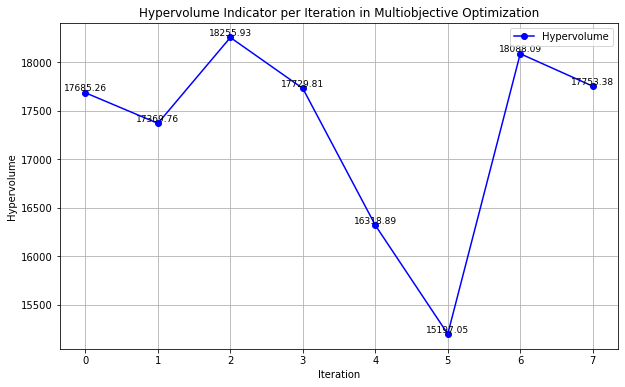

In [27]:
from pygmo import hypervolume


met1 = df_met['metric1'].values
met2 = df_met['metric2'].values
iters = df_met['iter'].values


# Combine met1 and met2 into a single array of solutions
solutions = np.column_stack((met1, met2))

# Define a reference point for hypervolume calculation
max_met1 = np.max(met1)
max_met2 = np.max(met2)
reference_point = [max_met1 + 0.1 * max_met1, max_met2 + 0.1 * max_met2]


def extract_pareto_front(solutions):
    """Extract the Pareto front from a set of solutions."""
    pareto_front = []
    for sol in solutions:
        if not is_pareto_dominated(sol, solutions):
            pareto_front.append(sol)
    return np.array(pareto_front)

def is_pareto_dominated(sol, front):
    """Check if a solution is dominated by any solution in the Pareto front."""
    return any(np.all(sol >= p) and np.any(sol > p) for p in front)

def compute_hypervolume(solutions, reference_point):
    """Compute the hypervolume of the Pareto front with respect to a reference point."""
    pareto_front = extract_pareto_front(solutions)
    if len(pareto_front) == 0:
        return 0
    hv = hypervolume(pareto_front)
    return hv.compute(reference_point)

# Compute hypervolume for each iteration
unique_iters = np.unique(iters)
hypervolumes = []

for i in unique_iters:
    iter_solutions = solutions[iters == i]
    hv = compute_hypervolume(iter_solutions, reference_point)
    hypervolumes.append(hv)

# Plotting the hypervolume
plt.figure(figsize=(10, 6))
iterations_range = range(len(unique_iters))

plt.plot(iterations_range, hypervolumes, marker='o', linestyle='-', color='blue', label='Hypervolume')
plt.xlabel('Iteration')
plt.ylabel('Hypervolume')
plt.title('Hypervolume Indicator per Iteration in Multiobjective Optimization')
plt.xticks(ticks=iterations_range, labels=unique_iters)
plt.legend()
plt.grid(True)

# Adding annotations for better readability
for i, hv in enumerate(hypervolumes):
    plt.text(i, hv, f"{hv:.2f}", horizontalalignment='center', verticalalignment='bottom', fontsize=9)

plt.show()

In [29]:
reference_point

[109.91867922000161, 311.2935401025995]